# Functions for Helping Translate Results to Real Observations

In this notebook we want to supply the user with a small suite of helper functions that will hopefully be useful in planning a given observation. All of these calculations can be done in the context of either set of isochrones that we investigate here.

In [1]:
# all we need is numpy, matplotlib, and a scipy interpolation class
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
# These are just preferences for making plots
# If you are getting errors from matplotlib, feel free to comment this out
plt.rc('font', **{'size': 8, 'sans-serif': ['Helvetica'], 'family': 'sans-serif'})
plt.rc('legend',**{'fontsize':6})                                             
plt.rc("text.latex", preamble=[
    "\\usepackage[T1]{fontenc}\\usepackage{amsmath}"])
plt.rc("text", usetex=True)
plt.rc('ps', usedistiller='xpdf')
plt.rc('savefig', **{'dpi': 300})

We begin by defining a lot of the same variables and loading a lot of the same pre-calcaulated values that we defined and pre-loaded in the `walkthrough.ipynb` notebook.

In [3]:
# First setting the range of metallicities and ages that are covered, these are our default values
metlist = np.array([0.5,0.25,0.0,-0.25,-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0,-2.25,-2.5,-2.75,-3.,-3.25])
agelist = np.array([8.95,9.,9.05,9.1,9.15,9.2,9.25,9.3,9.35,9.4,9.45,9.5,9.55,9.6,9.65,9.7,9.75,9.8,9.85,9.9,9.95,10.,10.05,10.1])
nmet  = len(metlist)
nage  = len(agelist)

In [4]:
# for MIST
nfilt = 7
filter_names = np.array([r"$F062$",r"$F087$",r"$F106$",r"$F129$",r"$F146$",r"$F158$",r"$F184$"])
# for Padova
#nfilt = 8
#filter_names = np.array([r"$F062$",r"$F087$",r"$F106$",r"$F129$",r"$F146$",r"$F158$",r"$F184$",r"$F213$"])

In [5]:
## For MIST
## Order here is F062, F087, F106, F129, F146, F158, F184
ps_detect_5slim = np.array([27.8, 27.5, 27.4, 27.3, 27.6, 27.3, 26.8])

## For Padova
## Order here is F062, F087, F106, F129, F146, F158, F184, F213/Ks
#ps_detect_5slim = np.array([27.8, 27.5, 27.4, 27.3, 27.6, 27.3, 26.8, 25.5])

In [6]:
## for MIST
## Here is the f_det file
fdet = np.load("data/fdet_mist.npy")
## The average luminosity file
lum = np.load("data/lum_mist.npy")
## And the Second luminosity moment file
L2 = np.load("data/l2_mist.npy")

## for Padova
## Here is the f_det file
#fdet = np.load("data/fdet_padova.npy")
## The average luminosity file
#lum = np.load("data/lum_padova.npy")
## And the Second luminosity moment file
#L2 = np.load("data/l2_padova.npy")

Okay, we've loaded them, now we want to assure that they have the right shapes. The same way we did in the `walkthrough.ipynb` notebook.

In [7]:
# the limiting magnitudes that fdet was calculated for should take up 
# the "first" slot in the filter dimension. It's the same for every population
# and filter, so there's a lot of repeated information
nmags = fdet.shape[2]
Mags = fdet[0,0,:,0]

In [8]:
# check that fdet is the correct shape
print("These should be the same: (%d, %d, %d, %d)"%(nmet,nage,nmags,nfilt+1),fdet.shape)

These should be the same: (16, 24, 100, 8) (16, 24, 100, 8)


In [9]:
# The shape of lum should be (nmet, nage, nfilt)
print("These should be the same: (%d, %d, %d)"%(nmet,nage,nfilt),lum.shape)

These should be the same: (16, 24, 7) (16, 24, 7)


In [10]:
# The shape of L2 should be (nmet, nage, nfilt, nmags)
print("These should be the same: (%d, %d, %d, %d)"%(nmet,nage,nfilt,nmags),L2.shape)

These should be the same: (16, 24, 7, 100) (16, 24, 7, 100)


Now we start with some of the useful functions. The first set defined here have to do with crowding which we cover at the end of the `walkthrough.ipynb` notebook. Each function is commented and should (hopefully!) be relatively straightforward to understand (with a little reading :) ). We begin by defining the same constants we needed for the crowding calculation before.

In [11]:
sigm = 0.01 # photometric precision of measurement in magnitudes
ares = (0.1)**2 # psf area in square arceseconds (assumed top hat) this should really vary with filter

And here are the useful functions...

In [12]:
# function for getting the final term in Equation 6 of our paper
def get_olsen_term(sigmaB,A,Bcut,Lavg,l2_Mags,l2):
    # interpolate the l2 values calculated for a range of limiting 
    # absolute magnitudes on to the limiting absolute magnitudes
    # calculated here
    L2_interp = np.interp(Bcut,l2_Mags[::-1],l2[::-1])
    # calculate the last term in Equation 8 in our paper
    return 2.5*np.log10(((sigmaB/1.086)**2)*(Lavg)/(A*L2_interp))

# function for determining the magnitude that we *can* get the 
# photometry of accurately if we are in the crowding limited 
# regime by interpolating
def get_Mcrowd(S,d,mi,aj,fk):
    # calculate distance modulus
    mu = 25 + 5*np.log10(d)
    # get the limiting magnitudes to check
    Mags = fdet[mi,aj,:,0]
    # get the olsen terms to interpolate between
    ols_terms = get_olsen_term(sigm,ares,Mags,lum[mi,aj,fk],fdet[mi,aj,:,0],L2[mi,aj,fk])
    # define the crowding limited surface brightness as a function 
    # of limiting magnitude of the observation
    lim_sb = 2*Mags + mu - ols_terms
    # interpolate the correct limiting magnitude based on when the 
    # surface brightness limit would be reached
    res = np.interp(S,lim_sb[::-1],Mags[::-1])
    return res
    
# function for getting the expected number of stars per square 
# arcsecond over some constant surface brightness area, also 
# returns whether or not the crowding limit has been reached
def getndet_singleSurf(S, d, texp, mi, aj, fk):
    # args S = surface brightness in this grid
    #      others are as below
    # calculate distance modulus
    mu = 25 + 5*np.log10(d)
    # and limiting magnitude
    Mlim = ps_detect_5slim[fk] - mu + 1.25*np.log10(texp/1e3)
    # total number density of stars
    ntot_here = 10**((S-mu)/-2.5)/lum[mi,aj,fk]
    # fraction of stars that are detected
    fdet_here = np.interp(Mlim,fdet[mi,aj,:,0][::-1],fdet[mi,aj,:,fk+1][::-1])

    # determine whether we are past the crowding limit in surface brightness
    ols_fac = get_olsen_term(sigm,ares,Mlim,lum[mi,aj,fk],fdet[mi,aj,:,0],L2[mi,aj,fk])
    # this is our limiting surface brightness for
    # crowding as a function of exposure time
    lso =  2*Mlim + mu - ols_fac
    crowded = lso>S
    if crowded:
        # if the region is crowded, we calculate the magnitude limit that it 
        # would not be crowded for and then the number of those stars that 
        # we end up detecting
        Mcrowd = get_Mcrowd(S,d,mi,aj,fk)
        fdet_crowd = np.interp(Mcrowd,fdet[mi,aj,:,0][::-1],fdet[mi,aj,:,fk+1][::-1])
        return (1.0,ntot_here*fdet_crowd)
    else:
        return (0.0,ntot_here*fdet_here)

# function for getting the expected number of resolved stars
# across a grid of surface brightness for a single age and 
# metallicity population at a given distance in a single band
# also returns map of where the observation is crowding limited
def getN_gridSurf(surfGrid, ang, d, texp, mi, aj, fk):
    # args surfGrid = square grid of surface brightnesses
    #      ang      = angular scale of one side of grid in arcsec
    #      d        = distance to population in Mpc
    #      texp     = exposure time in seconds
    #      mi       = metallicity index
    #      aj       = age index
    #      fk       = filter index
    # make sure that the grid is the right shape
    assert(len(surfGrid.shape)==2)
    assert(surfGrid.shape[0]==surfGrid.shape[1])
    # determine sky area of each cell in grid
    Nside = surfGrid.shape[0]
    area_sqarc = (ang/Nside)**2
    Nres = 0.0
    # create map to indicate where observation is crowded
    crowd_map = np.zeros(surfGrid.shape).flatten()
    for (j,surf) in enumerate(surfGrid.flatten()):
        (crowd,nhere) = getndet_singleSurf(surf,d,texp,mi,aj,fk)
        crowd_map[j] = crowd
        Nres += area_sqarc*nhere
    return (crowd_map.reshape(surfGrid.shape),Nres)

# a function to give you the surface brightness in another
# band given the surface brightness in some band and the 
# properties of the population
def convert_Sigma(surfIn,f_in,f_out,mi,aj):
    # args surfIn = surface brightness in reference band
    #      f_in   = index of reference filter
    #      f_out  = index of desired filter out
    #      mi     = metallicity index
    #      aj     = age index
    return surfIn - 2.5*np.log10(lum[mi,aj,f_out]/lum[mi,aj,f_in])

The functions in this next cell are only for drawing a Roman field of view on some image to give you a better idea of exactly what you are observing. Understanding the drawing functions is probably not so important.

In [13]:
## Here are some functions for drawing the Roman FoV
def rot_xy(x,y,phi):
    return (np.cos(phi)*x -np.sin(phi)*y,np.sin(phi)*x+np.cos(phi)*y)

def draw_detector(ax,ra0,dec0,L,phi,color):
    (x0,y0) = rot_xy(-L/2,-L/2,phi)
    (x1,y1) = rot_xy(L/2,-L/2,phi)
    (x2,y2) = rot_xy(L/2,L/2,phi)
    (x3,y3) = rot_xy(-L/2,L/2,phi)
    ax.plot([x0+ra0,x1+ra0],[y0+dec0,y1+dec0],c=color,lw=0.5)
    ax.plot([x1+ra0,x2+ra0],[y1+dec0,y2+dec0],c=color,lw=0.5)
    ax.plot([x2+ra0,x3+ra0],[y2+dec0,y3+dec0],c=color,lw=0.5)
    ax.plot([x3+ra0,x0+ra0],[y3+dec0,y0+dec0],c=color,lw=0.5)
    return None

def plot_RST_foV(ax,ra0,dec0,scal,phi,color):
    dL = 0.125*scal # side-length of detector in degrees
    dy1 = 0.01*scal
    dy2 = 0.03*scal
    dx = 0.02*scal
    (rl1,rr1) = (-(dx+dL)/2,(dx+dL)/2)
    (rl2,rr2) = (-3*(dx+dL)/2,3*(dx+dL)/2)
    (rl3,rr3) = (-5*(dx+dL)/2,5*(dx+dL)/2)
    dec2 = dL/4
    dec3 = dec2+(dL + dy1)/2
    (x,y) = rot_xy(rl1,0.,phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rr1,0.,phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rl1,0.+(dL + dy1),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rr1,0.+(dL + dy1),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rl1,0.-(dL + dy2),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rr1,0.-(dL + dy2),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)

    (x,y) = rot_xy(rl2,dec2,phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rr2,dec2,phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rl2,dec2+(dL + dy1),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rr2,dec2+(dL + dy1),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rl2,dec2-(dL + dy2),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rr2,dec2-(dL + dy2),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)

    (x,y) = rot_xy(rl3,dec3,phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rr3,dec3,phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rl3,dec3+(dL + dy1),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rr3,dec3+(dL + dy1),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rl3,dec3-(dL + dy2),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    (x,y) = rot_xy(rr3,dec3-(dL + dy2),phi)
    draw_detector(ax,ra0+x,dec0+y,dL,phi,color)
    return None

Okay, the next part is probably the most useful set of functions. These functions will take as input a map of surface brightness in a given band, the observation properties (pop. parameters, distance, $t_{\rm exp}$, etc.), and the positioning of the Roman FoV on the surface brightness map (center and rotation angle) and return the expected number of observed stars as well as the fraction of the FoV that is crowding limited.

In [14]:
def getN_chip(Sinterp, xc0, yc0, xcs, ycs, x0, y0, phi, ang, d, texp, mi, aj, fk):
    (x,y) = rot_xy(xc0,yc0,phi)
    surfGridi = Sinterp.ev(xcs+x+x0,ycs+y+y0)
    (cmi,Ni) = getN_gridSurf(surfGridi, ang, d, texp, mi, aj, fk)
    return (np.sum(cmi),Ni)
    
# Function to get the expected number of stars across the 
# whole Roman detector given an input surface brightness map
# and population parameters as well as FoV orientation
def getN_RST(surfGrid, ang, d, texp, mi, aj, fk, x0, y0, phi, nchip):
    # args surfGrid = square grid of surface brightnesses
    #      ang      = angular scale of one side of surfGrid in arcsec
    #      d        = distance to population in Mpc
    #      texp     = exposure time in seconds
    #      mi       = metallicity index
    #      aj       = age index
    #      fk       = filter index
    #      (x0,y0)  = position of center of Roman field
    #      phi      = rotation of Roman FoV
    #      nchip    = number of pixels to a side on a chip
    ## initialize the total number of detected stars dertecetd
    Ndet = 0
    ## initialize number of crowded pixels to 0
    Ncrowd = 0
    ## create an interpolation function, to be used below
    xlin = np.linspace(-1*ang/2,ang/2,surfGrid.shape[0])
    (xg,yg) = np.meshgrid(xlin,xlin)
    Surf_interp = interpolate.RectBivariateSpline(xlin, xlin, surfGrid)

    ## define some constants with relation to 
    ## the scale of the detector size/shape
    dL = 450 # side-length of detector in arcseconds
    dy1 = 36 # smaller vertical spacing between chips
    dy2 = 108 # larger vertical spacing
    dx = 72 # horizontal spacing between chips
    # x positions of 6 columns of chips
    (xl1,xr1) = (-(dx+dL)/2,(dx+dL)/2)
    (xl2,xr2) = (-3*(dx+dL)/2,3*(dx+dL)/2)
    (xl3,xr3) = (-5*(dx+dL)/2,5*(dx+dL)/2)
    y02 = dL/4 # y offset of 2nd/4th chip columns
    y03 = y02+(dL + dy1)/2 # y offset of outer chip columns
    yt = dL + dy1 # y offset from column center of top chip
    yb = -(dL + dy2) # y offset from column center of bottom chip
    # get a list together of all chip center coords
    chip_coords = [(xl1,0),(xr1,0),(xl1,yt),(xr1,yt),(xl1,yb),(xr1,yb),\
                   (xl1,y02),(xr1,y02),(xl1,y02+yt),(xr1,y02+yt),(xl1,y02+yb),(xr1,y02+yb),\
                   (xl1,y03),(xr1,y03),(xl1,y03+yt),(xr1,y03+yt),(xl1,y03+yb),(xr1,y03+yb)]
    # create the default chip grid
    chlin = np.linspace(-dL/2,dL/2,nchip)
    (xc,yc) = np.meshgrid(chlin,chlin)
    # rotate the default chip grid
    (xc,yc) = rot_xy(xc,yc,phi)
    ## Go through each chip
    for (xci,yci) in chip_coords:
        (Nci,Ni) = getN_chip(Surf_interp,xci,yci,xc,yc,x0,y0,phi,dL,d,texp,mi,aj,fk)
        Ncrowd += Nci
        Ndet += Ni    
    return (Ncrowd*1./(nchip**2 *18),Ndet)

These are some concrete (but not by any means actually realistic) examples of surface brightness profiles 'inspired by' observations of real galaxies. I say 'inspired by' because these are just radial profiles, the actual observations are not. One could use these as actual surface brightness profiles in a map to test the code used below. However, in the example below we will use a more realistic, simulated Halo.

In [17]:
# This one is for Centaurus A
def cenA_surf(r):
    ## parameters for a surface brightness profile of CenA
    # halo, made "by-eye" from Fig. 9 of Crnojevic et al. 2016
    # this is surface brightness in the r-band
    (Sa,ra,Sb,rb) = (27,60,32,420)
    m = (Sb-Sa)/(rb-ra)
    b = Sa - m*ra
    Slin = m*r+b

    Llin = 10**(Slin/-2.5)
    S2 = -2.5*np.log10(Llin + 10**(30/-2.5))
    return S2

# This one is for NGC 4244
def ngc4244_surf(r):
    # source is Radburn-Smith et al. 2011 Fig. 3
    # gives surface brightness in AB z band
    # r should be in. units of arcsec
    # ouput is mags/square arcsecond
    res = (21 + (3.5/425)*r)*(r<425) + (r>=425)*(13.68 + 0.02545*r)
    # we then apply a maximum surfae brightness (more realistic)
    Lres = 10**(res/-2.5)
    S2 = -2.5*np.log10(Lres + 10**(32/-2.5))
    return S2

(0, 1000)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


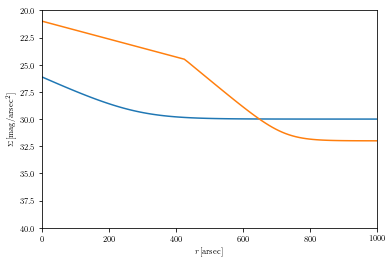

In [16]:
# Just displaying the profiles
rlin = np.linspace(0,1000,100)

plt.plot(rlin,cenA_surf(rlin))
plt.plot(rlin,ngc4244_surf(rlin))
plt.ylabel(r"$\Sigma \, [{\rm mag}/{\rm arsec}^2]$")
plt.xlabel(r"$r \, [{\rm arsec}]$")
plt.ylim(40,20)
plt.xlim(0,1000)

Okay, now you could use one of those surface brightness profiles to make a surface brightness map and apply the functions we have above to get the expected number of detected stars in a fake observation. Instead, I will use a more realitic surface birghtness map of a halo that I've made from the Bullock & Johnston 2005 halo simulations. I'll then plot the observation on top of the surface brightness map that I've made.

In [18]:
## Load the surface brightness map, which has been made in a separate file
halo02_surfR = np.load("../BJ_Halo_data/halo02_surfR.npy")
## and take a look at the shape, never a bad idea
halo02_surfR.shape

(300, 300)

Here I'm just going to list some of the galaxies of greatest interest to us and their distances for future reference.

 - M31 at 0.761 Mpc
 - M81 at 3.6 Mpc
 - M94 at 4.91 Mpc
 - NGC  253 at 3.5 Mpc
 - NGC 2403 at 2.9 Mpc
 - NGC 4244 at 4.3 Mpc
 - NGC 4565 at 13.1 Mpc
 - NGC 5023 at 5.4 Mpc
 - NGC 5907 at 16.4 Mpc
 - NGc 7814 at 12.2 Mpc

So we see that a good general value to deal with for the nearby-ish galaxies is about 4 Mpc. Below, we'll put together an example calculation using all of the functions we've introduced above. First we'll set up the calculation of how many stars we detected, then we'll plot the observation to get an idea of what exactly we are looking at.

In [19]:
# distance to obervation in Mpc
Dobs = 4
# conversion from kiloparsecs to degreees for this observation
kta = (1./(Dobs*1e3))*(180/np.pi)

# angular size of this observation in degrees
ang_size = 400*kta

# exposure time in seconds
texp = 1e3
# population parameters and filter choice
(meti,agej,filtk) = (10,22,0)
# position of center of Roman FoV on observation in arcseconds
(rst_x0,rst_y0) = (ang_size/16,-ang_size/16)
# rotation angle of Roman FoV
rst_phi = np.pi/4
# number of pixels to use in each chip of the WFI detector
# should be much less than 4096 (the actual number of pixels)
nchips = 64
(fcrowd,ndet) = getN_RST(halo02_surfR, 3600*ang_size, Dobs,texp,meti,agej,filtk,3600*rst_x0,3600*rst_y0, rst_phi,nchips)
print("The Fraction of the observation that is crowded is %1.3f"%(fcrowd))
print("We expect to detect %d stars from this observation"%(ndet))

The Fraction of the observation that is crowded is 0.450
We expect to detect 20322 stars from this observation


Then we want to make a plot of the observation.

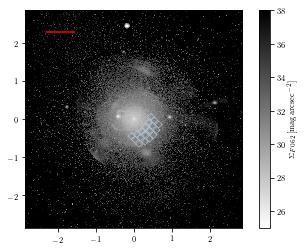

In [22]:
ax1 = plt.subplot(111)
# plot the surface birghtness map as an image
im = ax1.imshow(halo02_surfR,cmap='binary',extent = (-ang_size/2,ang_size/2,-ang_size/2,ang_size/2),vmin=25,vmax=38)
plt.colorbar(im,label=r"$\Sigma_{F062}\, [{\rm mag}\, {\rm arcsec}^{-2}]$") # with a color bar

# include a scale to indicate a distance of 50 kpc
plt.plot([-ang_size*0.4,-ang_size*0.4 + 50*kta],[ang_size*0.4,ang_size*0.4],'r')

# plot the Roman field of view on the image
plot_RST_foV(ax1,rst_x0,rst_y0,1.0,rst_phi,plt.cm.Blues(0.3))

Ideally, we want to look at this sort of observation over a number of different exposure times to try to get a handle on what sort of observation we would like to make. To that end, let's perform the above calculation for a bunch of exposure times and look at the dependence of the crowding fraction and number density of detected stars. This calculation will take awhile.

In [23]:
exp_ts = np.logspace(1,5,40)
(fcrowds1,ndets1) = ([],[])
(fcrowds2,ndets2) = ([],[])
for texp in exp_ts:
    (fcrowd,ndet) = getN_RST(halo02_surfR, 3600*ang_size, Dobs,texp,meti,agej,filtk,3600*rst_x0,3600*rst_y0, rst_phi,nchips)
    fcrowds1.append(fcrowd)
    ndets1.append(ndet)
    (fcrowd,ndet) = getN_RST(halo02_surfR, 3600*ang_size, Dobs,texp,meti,agej,filtk,-2*3600*rst_x0,2*3600*rst_y0, -1*rst_phi,nchips)
    fcrowds2.append(fcrowd)
    ndets2.append(ndet)
(fcrowds1,ndets1) = (np.array(fcrowds1),np.array(ndets1))
(fcrowds2,ndets2) = (np.array(fcrowds2),np.array(ndets2))

In [24]:
(texp_stream,ndet_stream) = np.load("data/stream_ndet.npy").T

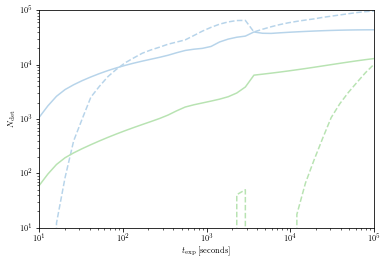

In [26]:
plt.plot(exp_ts,ndets1,c=plt.cm.Blues(0.3),label="Location 1")
plt.plot(exp_ts,1e5*fcrowds1,'--',c=plt.cm.Blues(0.3))
plt.plot(exp_ts,ndets2,c=plt.cm.Greens(0.3),label="Location 2")
plt.plot(exp_ts,1e5*fcrowds2,'--',c=plt.cm.Greens(0.3))
plt.ylabel(r"$N_{\rm det}$")
plt.xlabel(r"$t_{\rm exp} \, [{\rm seconds}]$")
plt.ylim(1e1,1e5)
plt.xlim(1e1,1e5)
plt.xscale("log")
plt.yscale("log")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


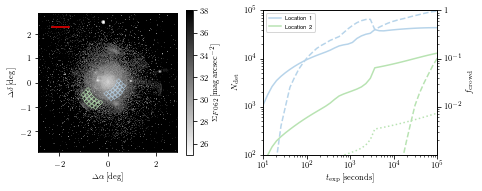

In [27]:
## Should remember to remove this before publishing

ax1 = plt.subplot(121)
# plot the surface birghtness map as an image
im = ax1.imshow(halo02_surfR,cmap='binary',extent = (-ang_size/2,ang_size/2,-ang_size/2,ang_size/2),vmin=25,vmax=38)
plt.colorbar(im,label=r"$\Sigma_{F062}\, [{\rm mag}\, {\rm arcsec}^{-2}]$") # with a color bar

# include a scale to indicate a distance of 50 kpc
plt.plot([-ang_size*0.4,-ang_size*0.4 + 50*kta],[ang_size*0.4,ang_size*0.4],'r')

# plot the Roman field of view on the image
plot_RST_foV(ax1,rst_x0,rst_y0,1.0,rst_phi,plt.cm.Blues(0.3))
plot_RST_foV(ax1,-2*rst_x0,2*rst_y0,1.0,-1*rst_phi,plt.cm.Greens(0.3))

ax1.set_xlabel(r"$\Delta \alpha \, [{\rm deg}]$")
ax1.set_ylabel(r"$\Delta \delta \, [{\rm deg}]$")

ax2 = plt.subplot(122)
ax2.plot(exp_ts,ndets1,c=plt.cm.Blues(0.3),label="Location 1")
ax2.plot(texp_stream,ndet_stream,":",c=plt.cm.Greens(0.3))
ax2.plot(exp_ts,1e5*fcrowds1,'--',c=plt.cm.Blues(0.3))
ax2.plot(exp_ts,ndets2,c=plt.cm.Greens(0.3),label="Location 2")
ax2.plot(exp_ts,1e5*fcrowds2,'--',c=plt.cm.Greens(0.3))
ax2.set_ylabel(r"$N_{\rm det}$")
ax2.set_xlabel(r"$t_{\rm exp} \, [{\rm seconds}]$")
ax2.set_ylim(1e2,1e5)
ax2.set_xlim(1e1,1e5)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.legend()

ax2c = ax2.twinx()
ax2c.set_yscale("log")
ax2c.set_ylim(ax2.get_ylim())
ax2c.set_yticks([1e3,1e4,1e5])
ax2c.set_yticklabels(["$10^{-2}$","$10^{-1}$","$1$"])
ax2c.set_ylabel(r"$f_{\rm crowd}$")


plt.gcf().set_size_inches((2.*3.37, 3.37*.8))
plt.tight_layout()
plt.savefig("../plotting/Figures/halo_obs.png")